# Etude de l'entropie

---

Ce notebook fait partie du cadre du projet [PiR] réalisé dans le cadre de l'INSA de Rennes et du laboratoire de l'IRISA

In [19]:
%load_ext autoreload
%autoreload 2

from IPython.display import display, HTML
import os
from os import path
import sys
cwd = os.getcwd().split(os.path.sep)

# point to the git repository
while cwd[-1] != "ExplanationPairSentencesTasks":
    os.chdir("..")
    cwd = os.getcwd().split(os.path.sep)
print(f">> current directory : {os.getcwd()}")

# add the root directory
sys.path.append(os.path.join(os.getcwd(), "src"))

# cache and data cache
cache_path = path.join(os.getcwd() ,'.cache')
dataset_path = path.join(cache_path, 'dataset')
log_path = path.join(cache_path, 'logs')
model_path = path.join(cache_path, 'models')
print(f">> cache path : {cache_path}")
print(f">> model path : {model_path}")
print(f">> dataset path : {dataset_path}")
print(f">> logs path : {log_path}")

# import the different modules
from src.data_module.hatexplain import HateXPlainDM
from pur_attention import AttitModel
from modules import metrics
from notebooks.attention_based.utils.ckp_config import *

# external librairies
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
from tqdm.notebook import tqdm

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f">> device : {DEVICE}")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
>> current directory : C:\Users\loicf\Documents\IRISA\ExplanationPairSentencesTasks
>> cache path : C:\Users\loicf\Documents\IRISA\ExplanationPairSentencesTasks\.cache
>> model path : C:\Users\loicf\Documents\IRISA\ExplanationPairSentencesTasks\.cache\models
>> dataset path : C:\Users\loicf\Documents\IRISA\ExplanationPairSentencesTasks\.cache\dataset
>> logs path : C:\Users\loicf\Documents\IRISA\ExplanationPairSentencesTasks\.cache\logs
>> device : cuda


## Etude sur les réseaux d'attention pur entrainés pour une tête et plusieurs couches

### Travail sur le jeu de données *HateXPlain*

In [20]:
# the hatexplain dataset
dm_kwargs = dict(cache_path=dataset_path,
                 batch_size=32,
                 num_workers=0,
                 n_data=999,
                 pur_attention=True)
dm = HateXPlainDM(**dm_kwargs)
dm.prepare_data()
dm.setup(stage="test")

test_dataloader = dm.test_dataloader() # load the test dataset

In [21]:
model_args = dict(
        cache_path=model_path,
        mode="exp",
        vocab=dm.vocab,
        lambda_entrop=0,
        lambda_supervise=0,
        lambda_lagrange=0,
        pretrained_vectors="glove.840B.300d",
        num_layers=1,
        num_heads=1,
        d_embedding=300,
        data="hatexplain",
        num_class=dm.num_class,
        opt="adadelta"
    )

In [22]:
# dictionnary where we will store the value of the entropy
# TODO : travailler pour aussi faire apparaître la variance de l'entropie.
entropy_dict = {
    f"n_layer={i+1}" : np.zeros((i+1,)) for i in range(10)
}

In [23]:
%%capture
for l in range(1) :
    # for each iteration update the model args
    model_args["num_layers"] = l+1
    ckp, hparams = gen_ckp(name="PurAttention",num_layers=l+1, num_heads=1, log_path=log_path, dataset="hatexplain")
    model = AttitModel.load_from_checkpoint(ckp, hparams_file=hparams, **model_args)
    model = model.eval()

    with torch.no_grad():
        model = model.to(DEVICE)
        pbar = tqdm(enumerate(test_dataloader), total = int(999/32))
        for id_batch, batch in pbar:
            pbar.set_description("proceed the entropy maps")
            ids = batch["token_ids"].to(DEVICE)
            padding_mask = batch["padding_mask"].bool().to(DEVICE)
            output = model(ids=ids, mask=padding_mask)

            cl = output["logits"].argmax(dim=-1) # search for the class
            # process the attention tensor
            attention_tensor = torch.stack(output["attn_weights"], dim=1) # shape [b, l, T, T]
            agreg_mask = ((~padding_mask).float()).clone().detach().to(DEVICE) \
                .unsqueeze(1).unsqueeze(1) \
                .repeat(1, 1, batch['token_ids'].shape[1], 1)
            pad_mask = torch.transpose(agreg_mask, dim0=2, dim1=3)
            attention_tensor = torch.mul(attention_tensor, pad_mask)
            a_hat = attention_tensor.sum(dim=2)

            # ENTROPY : calculation of the entropy on each layer
            for i in range(l+1):
                print("")
                entropy_mask = padding_mask.float().clone().detach().to(DEVICE)
                entropy_mask[:, 0] = 1.  # we don't take into account the CLS token
                # we only look at the layer i
                a_hat_entropy = metrics.entropy(a_hat[:, i, :], entropy_mask.bool(), normalize=True)
                entropy_dict[f"n_layer={l+1}"][i] += a_hat_entropy.sum().item()

    model = model.cpu()
    del model
    torch.cuda.empty_cache()

# mean the dict
for k in entropy_dict:
    entropy_dict[k] = entropy_dict[k] / 999
;

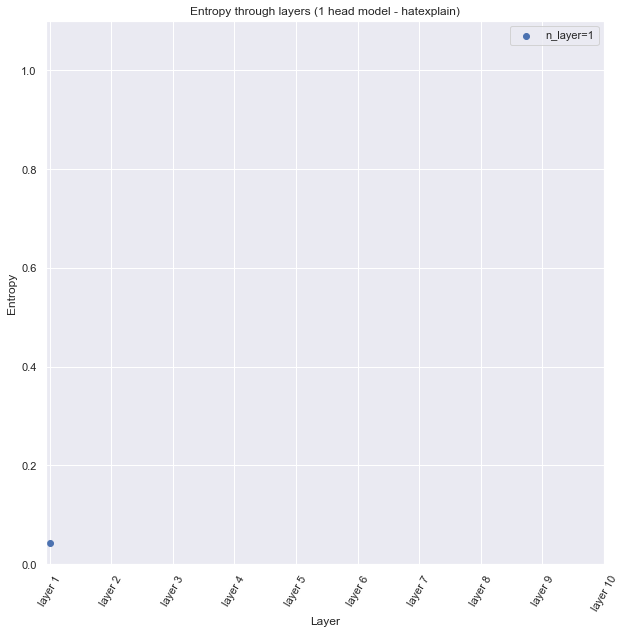

In [24]:
fig = plt.figure(figsize=(10,10))
txt = plt.title("Entropy through layers (1 head model - hatexplain)")
for i in range(1):
    plt.scatter(list(range(i+1)) ,entropy_dict[f"n_layer={i+1}"], label=f"n_layer={i+1}")
plt.ylim((0, 1.1))

plt.ylabel("Entropy")
plt.xlabel("Layer")

x = list(range(0, 10))
plt.xticks(x, [f"layer {l+1}" for l in x], rotation=60)

txt = plt.legend()
plt.savefig(os.path.join(os.getcwd(),".cache","fig","hatexplain_h=1_l=[1,10]", "scatter_entropy.png"))

In [16]:
%%capture
for l in range(1) :
    # for each iteration update the model args
    model_args["num_layers"] = l+1
    ckp, hparams = gen_ckp(name="PurAttention",num_layers=l+1, num_heads=1, log_path=log_path, dataset="hatexplain")
    model = AttitModel.load_from_checkpoint(ckp, hparams_file=hparams, **model_args)
    model = model.eval()

    with torch.no_grad():
        model = model.to(DEVICE)
        pbar = tqdm(enumerate(test_dataloader), total = int(999/32))
        for id_batch, batch in pbar:
            pbar.set_description("proceed the entropy maps")
            ids = batch["token_ids"].to(DEVICE)
            padding_mask = batch["padding_mask"].bool().to(DEVICE)
            output = model(ids=ids, mask=padding_mask)

            # process the attention tensor
            attention_tensor = torch.stack(output["attn_weights"], dim=1) # shape [b, l, T, T]
            a_hat = attention_tensor[:,:,0,:] # only choose the CLS line

            # ENTROPY : calculation of the entropy on each layer
            for i in range(l+1):
                print("")
                entropy_mask = padding_mask.float().clone().detach().to(DEVICE)
                entropy_mask[:, 0] = 1.  # we don't take into account the CLS token
                # we only look at the layer i
                a_hat_entropy = metrics.entropy(a_hat[:, i, :], entropy_mask.bool(), normalize=True)
                entropy_dict[f"n_layer={l+1}"][i] += a_hat_entropy.sum().item()

    model = model.cpu()
    del model
    torch.cuda.empty_cache()

# mean the dict
for k in entropy_dict:
    entropy_dict[k] = entropy_dict[k] / 999
;

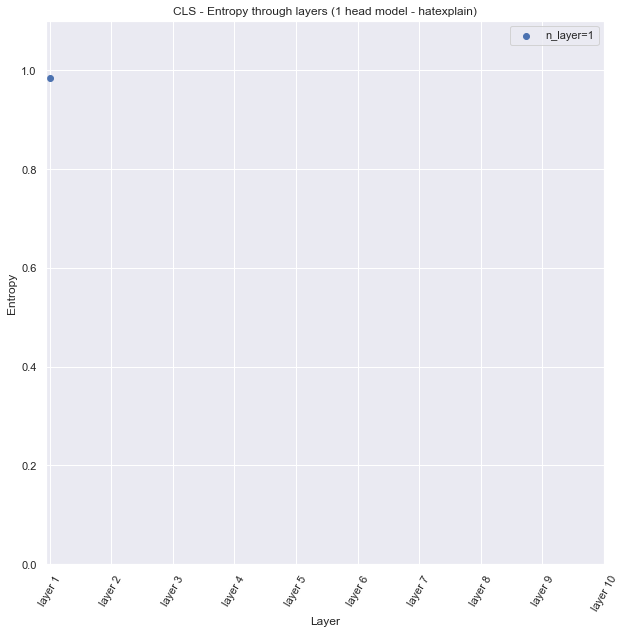

In [17]:
fig = plt.figure(figsize=(10,10))
txt = plt.title("CLS - Entropy through layers (1 head model - hatexplain)")
for i in range(1):
    plt.scatter(list(range(i+1)) ,entropy_dict[f"n_layer={i+1}"], label=f"n_layer={i+1}")
plt.ylim((0, 1.1))

plt.ylabel("Entropy")
plt.xlabel("Layer")

x = list(range(0, 10))
plt.xticks(x, [f"layer {l+1}" for l in x], rotation=60)

txt = plt.legend()
plt.savefig(os.path.join(os.getcwd(),".cache","fig","hatexplain_h=1_l=[1,10]", "cls_scatter_entropy.png"))